In [2]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import pytz

# 表示設定
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 180)

# === 入力CSVパス（必要に応じて変更） ===
CSV_PATH = r"C:\Users\Owner\youtube\trend_data\trending_JP_category24_no_shorts_20251009.csv"

# タイムゾーン
TZ = pytz.timezone("Asia/Tokyo")

now_utc = datetime.now(timezone.utc)
now_jst = now_utc.astimezone(TZ)
now_utc, now_jst


(datetime.datetime(2025, 10, 9, 14, 33, 37, 249666, tzinfo=datetime.timezone.utc),
 datetime.datetime(2025, 10, 9, 23, 33, 37, 249666, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>))

In [3]:
# %%
df = pd.read_csv(CSV_PATH)

# publishedAt を datetime（JST）へ
# 例: 2025-10-09T02:34:56Z
df["publishedAt_utc"] = pd.to_datetime(df["publishedAt"], utc=True, errors="coerce")
df["publishedAt_jst"] = df["publishedAt_utc"].dt.tz_convert(TZ)

# 経過時間（時間）
df["hours_since_publish"] = (now_jst - df["publishedAt_jst"]).dt.total_seconds() / 3600.0

# 視聴速度（時間あたりビュー）
df["views_per_hour"] = np.where(df["hours_since_publish"] > 0,
                                df["viewCount"] / df["hours_since_publish"],
                                np.nan)

# 安全なlike率・comment率（ゼロ割対策）
df["like_rate"] = df["likeCount"] / np.where(df["viewCount"]>0, df["viewCount"], np.nan)
df["comment_rate"] = df["commentCount"] / np.where(df["viewCount"]>0, df["viewCount"], np.nan)

# 曜日・時間帯（JST）
df["dow"] = df["publishedAt_jst"].dt.day_name(locale="ja_JP")  # 日本語ロケールが無い環境は英語表記になります
df["hour"] = df["publishedAt_jst"].dt.hour

# 概要チェック
df.head(3)


,snapshot_at_utc,videoId,title,description,channelId,channelTitle,publishedAt,categoryId,tags,thumbnail,viewCount,likeCount,commentCount,duration,publishedAt_utc,publishedAt_jst,hours_since_publish,views_per_hour,like_rate,comment_rate,dow,hour
0,2025-10-09T14:26:53.916776Z,LdOvyJR_JSY,服のセンスが全くない！ #anime #animemoments,NaN,UCY6rwkad54II2EOjlLOne_A,Kiriyamaaa,2025-10-06T22:00:34Z,22,NaN,https://i.ytimg.com/vi/LdOvyJR_JSY/hqdefault.jpg,2265432,110001.0,516,PT1M1S,2025-10-06 22:00:34+00:00,2025-10-07 07:00:34+09:00,64.550903,35095.279938,0.048556,0.000228,火曜日,7
1,2025-10-09T14:26:53.916776Z,pRTpYoATSrQ,声優陣がレジェンド過ぎる🤣,@万舟ケン,UCr63OFPp6W8Qy8tNIBwINXA,万舟ケン,2025-10-04T06:55:44Z,22,NaN,https://i.ytimg.com/vi/pRTpYoATSrQ/hqdefault.jpg,3073547,76915.0,1329,PT1M22S,2025-10-04 06:55:44+00:00,2025-10-04 15:55:44+09:00,127.631458,24081.421950,0.025025,0.000432,土曜日,15
2,2025-10-09T14:26:53.916776Z,g7FvtEa-59E,#クチャラー 直してもらうべき？#ショートドラマ #夫婦の日常,しまうま劇場Vol.145\n「クチャラー地獄」\n\n出演：#安田乙葉 #山本章博 #大石...,UCxUP7uPbcob4bDfP2osdOlw,しまうま劇場,2025-10-05T22:00:50Z,24,NaN,https://i.ytimg.com/vi/g7FvtEa-59E/hqdefault.jpg,1946484,41526.0,512,PT1M28S,2025-10-05 22:00:50+00:00,2025-10-06 07:00:50+09:00,88.546458,21982.629669,0.021334,0.000263,月曜日,7


In [4]:
# %%
print("=== shape ===")
print(df.shape)

print("\n=== columns ===")
print(df.columns.tolist())

print("\n=== dtypes ===")
print(df.dtypes)

print("\n=== missing ===")
print(df.isna().sum())

print("\n=== describe (主要数値) ===")
num_cols = ["rank","duration_seconds","viewCount","likeCount","commentCount","hours_since_publish","views_per_hour","like_rate","comment_rate"]
print(df[num_cols].describe().T)


=== shape ===
(20, 22)

=== columns ===
['snapshot_at_utc', 'videoId', 'title', 'description', 'channelId', 'channelTitle', 'publishedAt', 'categoryId', 'tags', 'thumbnail', 'viewCount', 'likeCount', 'commentCount', 'duration', 'publishedAt_utc', 'publishedAt_jst', 'hours_since_publish', 'views_per_hour', 'like_rate', 'comment_rate', 'dow', 'hour']

=== dtypes ===
snapshot_at_utc                            object
videoId                                    object
title                                      object
description                                object
channelId                                  object
channelTitle                               object
publishedAt                                object
categoryId                                  int64
tags                                       object
thumbnail                                  object
viewCount                                   int64
likeCount                                 float64
commentCount                     

KeyError: "['rank', 'duration_seconds'] not in index"

KeyError: 'duration_seconds'

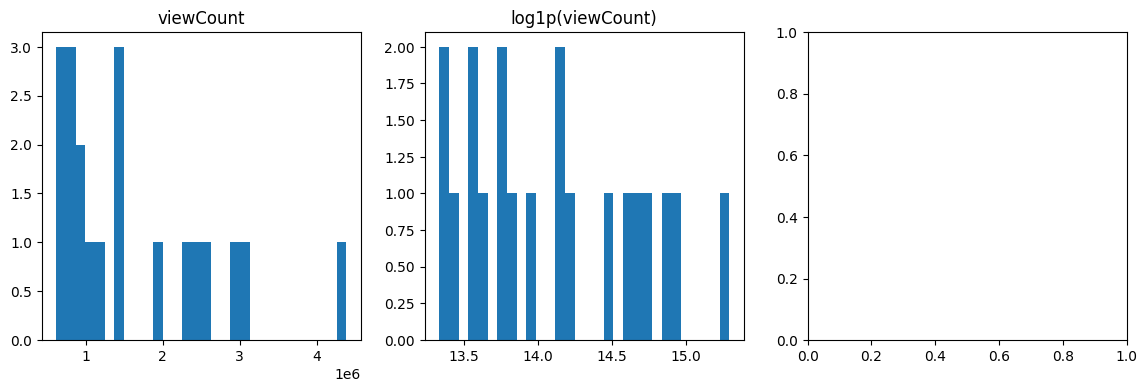

In [5]:
# %%
fig, axes = plt.subplots(1, 3, figsize=(14,4))
axes[0].hist(df["viewCount"].dropna(), bins=30)
axes[0].set_title("viewCount")
axes[1].hist(np.log1p(df["viewCount"].dropna()), bins=30)
axes[1].set_title("log1p(viewCount)")
axes[2].hist(df["duration_seconds"].dropna(), bins=30)
axes[2].set_title("duration_seconds")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(np.log1p(df["views_per_hour"].dropna()), bins=30)
plt.title("log1p(views_per_hour)")
plt.show()


In [6]:
# %% 上位/下位の抽出（views_per_hour基準 と viewCount基準）
top_vph = df.sort_values("views_per_hour", ascending=False)[["videoId","title","channelTitle","views_per_hour","viewCount","hours_since_publish"]].head(10)
bot_vph = df.sort_values("views_per_hour", ascending=True)[["videoId","title","channelTitle","views_per_hour","viewCount","hours_since_publish"]].head(10)

top_views = df.sort_values("viewCount", ascending=False)[["videoId","title","channelTitle","viewCount","views_per_hour","hours_since_publish"]].head(10)

print("=== views/hour 上位 ===")
display(top_vph)
print("=== views/hour 下位 ===")
display(bot_vph)
print("=== 総再生数 上位 ===")
display(top_views)


=== views/hour 上位 ===


,videoId,title,channelTitle,views_per_hour,viewCount,hours_since_publish
0,LdOvyJR_JSY,服のセンスが全くない！ #anime #animemoments,Kiriyamaaa,35095.279938,2265432,64.550903
10,qbN-nb-cgso,モテる異能力者のTier表作ってみた #パラ高,私立パラの丸高校,24641.126351,752617,30.543125
1,pRTpYoATSrQ,声優陣がレジェンド過ぎる🤣,万舟ケン,24081.421950,3073547,127.631458
8,MoeAOXJ_bSM,男女の旅の違い,まつした,23961.245225,660114,27.549236
18,LYD_tSRtjdg,超能力のガチャガチャ【アニメ】,マイ部アニメ,22333.953673,648958,29.057014
2,g7FvtEa-59E,#クチャラー 直してもらうべき？#ショートドラマ #夫婦の日常,しまうま劇場,21982.629669,1946484,88.546458
3,HJjFikegRi8,親友に絶対見抜けないマジックしてみたww,ブルーシー【Blue Sea】,20859.316282,1435331,68.810069
7,6KoC7AgSOUQ,㊗️100万再生！三原じゅん子、情けない逃げっぷり大拡散されるw,ダックスクープ【ネットの反応】,18968.949328,995966,52.505069
15,k-JzfFAYoLU,犬の視点から、人生の酸いも甘いも理解する#映画レビュー #映画紹介 #映画解説 #film ...,slin映画館,17560.241162,4382974,249.596458
4,YGmfaJEHi0I,虫入ってる料理屋VS昆虫食のママ,ボチリスト,17361.738053,929621,53.544236


=== views/hour 下位 ===


,videoId,title,channelTitle,views_per_hour,viewCount,hours_since_publish
19,3FweuY__yhA,大友は加藤の裏を引きずり出したんだ！#アウトレイジ,Bai Cai Talks,8010.100501,617250,77.058958
16,kRQrfRhNK80,【2人の表情は】高市新総裁…選出の瞬間！小泉進次郎氏は逆転ならず…決選投票,日テレNEWS,9527.144951,796380,83.590625
17,SHspk9k9Jww,家にトレイが無くて、とあるもので代用させてもらっちゃった😜社員食堂無かったからめっちゃ憧れだ...,もとき,10480.919488,802286,76.547292
13,E6Oj3d_u7GU,MAX何時間までありますか？😃 #あるある #友達あるある #サッカーあるある #お笑い #...,テセチャンネル,12099.294569,1495151,123.573403
5,HOh989cKuuU,㊗️150万再生！宮沢孝幸ブチギレ！西田亮介とワクチン論争をめぐり地上波でケンカ勃発！#ワク...,劇団ひとこと,12657.043559,962671,76.058125
11,TIloLN7niT0,明日は雨だぞ窓閉めとけよ（※ 日常感リアルすぎｗ）🌧️🪟😅,トスビ / Tosubi,12795.813362,1120317,87.553403
14,p3dLe9OR6E0,美しい容姿ゆえに男として生きる少女,3分シネマ,13009.494224,2595395,199.500069
9,d4X2aqRp22A,ノミに恋した髭中のシラミ,映画ねこ,13534.430935,1386844,102.467847
12,1ciPY0akJ0c,下水は情報の宝庫!?薬物使用がバレる理由がすごすぎる｜ドーピングトーキング毎週土曜夜10時〜...,ABEMA バラエティ【公式】,14979.356984,2959302,197.558680
6,XEG-bhwNTB0,【みんなは気づける？】ポケモン違和感クイズを街中で挑戦してもらったら強者すぎたww #ポケモ...,DOPA!オリパ,16056.384041,2385061,148.542847


=== 総再生数 上位 ===


,videoId,title,channelTitle,viewCount,views_per_hour,hours_since_publish
15,k-JzfFAYoLU,犬の視点から、人生の酸いも甘いも理解する#映画レビュー #映画紹介 #映画解説 #film ...,slin映画館,4382974,17560.241162,249.596458
1,pRTpYoATSrQ,声優陣がレジェンド過ぎる🤣,万舟ケン,3073547,24081.421950,127.631458
12,1ciPY0akJ0c,下水は情報の宝庫!?薬物使用がバレる理由がすごすぎる｜ドーピングトーキング毎週土曜夜10時〜...,ABEMA バラエティ【公式】,2959302,14979.356984,197.558680
14,p3dLe9OR6E0,美しい容姿ゆえに男として生きる少女,3分シネマ,2595395,13009.494224,199.500069
6,XEG-bhwNTB0,【みんなは気づける？】ポケモン違和感クイズを街中で挑戦してもらったら強者すぎたww #ポケモ...,DOPA!オリパ,2385061,16056.384041,148.542847
0,LdOvyJR_JSY,服のセンスが全くない！ #anime #animemoments,Kiriyamaaa,2265432,35095.279938,64.550903
2,g7FvtEa-59E,#クチャラー 直してもらうべき？#ショートドラマ #夫婦の日常,しまうま劇場,1946484,21982.629669,88.546458
13,E6Oj3d_u7GU,MAX何時間までありますか？😃 #あるある #友達あるある #サッカーあるある #お笑い #...,テセチャンネル,1495151,12099.294569,123.573403
3,HJjFikegRi8,親友に絶対見抜けないマジックしてみたww,ブルーシー【Blue Sea】,1435331,20859.316282,68.810069
9,d4X2aqRp22A,ノミに恋した髭中のシラミ,映画ねこ,1386844,13534.430935,102.467847
